## Correlations between ASC and heat transport in $z^*$ layers

In [1]:
import xarray as xr
from dask.distributed import Client
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml


In [2]:
client = Client(threads_per_worker = 1)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that i

In [3]:
figdir = '/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/'

In [4]:
u_along = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/ASC_z_daily_10deg/OM2_01_iaf_cycle3/*')

In [5]:
%%time
import intake

cat = intake.cat.access_nri
iaf_run = '01deg_jra55v140_iaf_cycle3'


dzt = cat[iaf_run].search(variable=['dzt'])



CPU times: user 5.35 s, sys: 3.67 s, total: 9.03 s
Wall time: 5.69 s


In [6]:
dzt = cat[iaf_run].search(variable=['dzt']).to_dask(    
    xarray_open_kwargs={
        "chunks" : "auto",
    }).dzt.sel(yt_ocean=slice(-90,-60))
dzt = dzt.isel(time=slice(0,12))

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


In [7]:
thickness = dzt.mean(dim=['time','yt_ocean', 'xt_ocean']).compute()


In [8]:
#selecting the depth for cummulative mean
depths = thickness.st_ocean.sel(st_ocean=slice(0,2100))

In [9]:
#Loading data before running the code
u_along.load()
print('daily data loaded')

daily data loaded


In [10]:
# test code with one depth
i=3
u_along_mean = u_along.U.sel(st_ocean=slice(None,depths[i])).weighted(thickness).mean('st_ocean').compute()
u_along_mean_annual = u_along_mean.groupby('time.year').mean('time').compute()

In [11]:
#removing spurious 0's from previous binning
u_along = u_along.where(u_along!=0)

In [12]:
#now running intereatively for each cell
u_along_mean_flag = 1 + 0*u_along.U.sel(st_ocean=slice(0,2100)).copy()
u_along_mean_z = u_along_mean_flag*np.nan

for i in tqdm(range(len(depths))):
    U_cummean =  u_along.U.sel(st_ocean=slice(None,depths[i])).weighted(thickness).mean('st_ocean')
    u_along_mean_z[:,i,:] = U_cummean.values
#computing annual means
u_along_mean_z = u_along_mean_z*u_along_mean_flag #removing the values propagation done by the cummean
u_along_mean_annual_z = u_along_mean_z.groupby('time.year').mean('time').compute()


00%|██████████| 55/55 [00:09<00:00,  5.73it/s]

Text(0.5, 1.0, 'Cumulative mean minus actual mean')

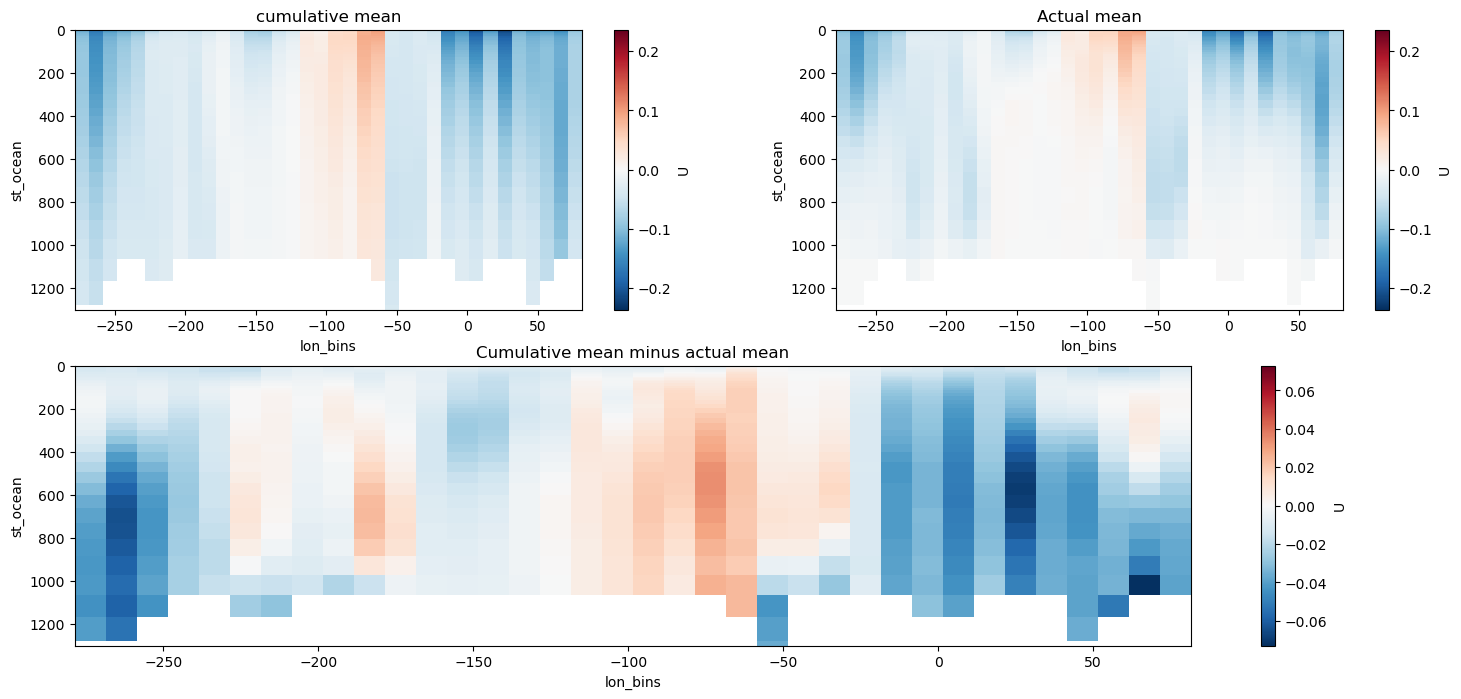

In [13]:
#sanity check, lets compare o=if the values are different in different depths
plt.figure(figsize=(18,8))

plt.subplot(2,2,1)
u_along_mean_z.mean('time').plot(y='st_ocean')
plt.ylim(1300,0); plt.title('cumulative mean')

plt.subplot(2,2,2)
u_along.U.mean('time').plot(y='st_ocean')
plt.ylim(1300,0); plt.title('Actual mean')

plt.subplot(2,1,2)
(u_along_mean_z.mean('time')- u_along.U.mean('time') ) .plot(y='st_ocean')
plt.ylim(1300,0); plt.title('Cumulative mean minus actual mean')

In [14]:
#importing CSHT in density bins
CSHT_along_10deg = xr.open_mfdataset('/g/data/e14/fbd581/ASC_project/Lon_binning/CSHT_ZC_potrho0_10degBins.nc',\
                               chunks = {'time' : 100,'lon_bins':12})

In [15]:
age_mask_daily = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/age_mask_daily/OM2_01_iaf_cycle3/*.nc')

In [16]:
%%time
CSHT_CDW = (CSHT_along_10deg.CSHT_ZC_lon_binned * age_mask_daily.CDW_mask).sum('potrho0').compute()

CPU times: user 12.6 s, sys: 979 ms, total: 13.5 s
Wall time: 14 s


calculating annual means

In [17]:
CSHT_CDW_annual = CSHT_CDW.resample(time='1Y').mean()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/xarray/groupers.py:530: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


calculating daily climatology

In [18]:
CSHT_CDW_dayclim= CSHT_CDW.groupby('time.dayofyear').mean()
u_along_mean_z_dayclim = u_along_mean_z.groupby('time.dayofyear').mean()

Calculating correlations

In [19]:
u_along_mean_annual_z_forcorr = u_along_mean_annual_z.rename({'year':'time'})
u_along_mean_annual_z_forcorr['time'] = CSHT_CDW_annual.time

In [20]:
import scipy.stats as stats
def correlation_analysis(U_along_daily_binned,  CSHT_daily_binned,dim='time'):
    
    if "time" not in U_along_daily_binned.dims:
        U_along_daily_binned = U_along_daily_binned.rename({'dayofyear':'time'})
        CSHT_daily_binned = CSHT_daily_binned.rename({'dayofyear':'time'})
    len_lonbin = len(U_along_daily_binned.lon_bins) # 10deg bins

    slope_daily = U_along_daily_binned.isel(time=0)*np.nan
    stderr_daily = U_along_daily_binned.isel(time=0)*np.nan
    r_sq_daily = U_along_daily_binned.isel(time=0)*np.nan
    
    for i in range(len_lonbin):
        for z in range(len(U_along_daily_binned.st_ocean)):
            slope_daily[z,i] = stats.linregress(U_along_daily_binned.isel(lon_bins=i,st_ocean=z), CSHT_daily_binned.isel(lon_bins=i)/1e12).slope
            stderr_daily[z,i] = stats.linregress(U_along_daily_binned.isel(lon_bins=i,st_ocean=z), CSHT_daily_binned.isel(lon_bins=i)/1e12).stderr
            r_sq_daily[z,i] = stats.linregress(U_along_daily_binned.isel(lon_bins=i,st_ocean=z), CSHT_daily_binned.isel(lon_bins=i)/1e12).rvalue**2
        
    return slope_daily, stderr_daily, r_sq_daily

In [21]:
#annuals
slope_annual, stderr_annual, r2_annual = correlation_analysis(u_along_mean_annual_z_forcorr,\
                                                              CSHT_CDW_annual)

#daily_climatology
slope_dailyclim, stderr_dailyclim, r2_dailyclim = correlation_analysis(u_along_mean_z_dayclim,\
                                                                       CSHT_CDW_dayclim)


In [22]:
#annuals
slope_annual_layerwise, stderr_annual_layerwise, r2_annual_layerwise = correlation_analysis(u_along.U.resample(time='1Y').mean(),\
                                                              CSHT_CDW_annual)

#daily_climatology
slope_dailyclim_layerwise, stderr_dailyclim_layerwise, r2_dailyclim_layerwise = correlation_analysis(u_along.U.groupby('time.dayofyear').mean(),\
                                                                       CSHT_CDW_dayclim)


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/xarray/groupers.py:530: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


In [23]:
#determination coefficients
r2_ASCz_cummean_daily = (xr.corr(u_along_mean_z,CSHT_CDW,dim = 'time')**2).compute() #daily
r2_ASCz_cummean_annual = (xr.corr(u_along_mean_annual_z_forcorr,CSHT_CDW_annual,dim = 'time')**2).compute() #annual
r2_ASCz_cummean_annual_dailyclim = (xr.corr(u_along_mean_z_dayclim,CSHT_CDW_dayclim,dim = 'dayofyear')**2).compute() #daily climatology

In [24]:
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
longitude_inds = np.array([5,36-15, 14, 3,10,17,36-12,36-10, 36-1,1])
regions_abridged = ['Mertz','WAP', 'Getz', 'Totten',\
           'Glomar', 'Amundsen', 'Filchner', \
           'Riiser-Larsen', 'Amery', 'Denman']

In [25]:
import cmocean.cm as cmocean
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [26]:
cmap = discrete_cmap(10, cmocean.dense)

/jobfs/154931058.gadi-pbs/ipykernel_2253783/3548735741.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = plt.cm.get_cmap(base_cmap)


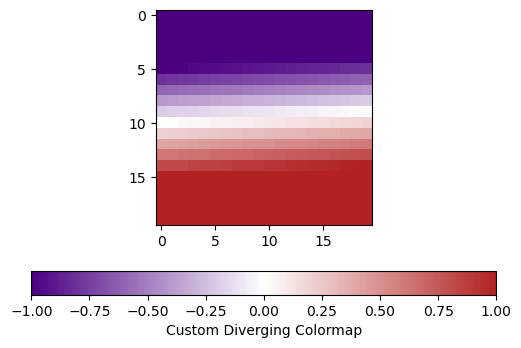

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define a custom colormap
colors = ["indigo", "white", "firebrick"]  # Negative, Zero, Positive
experimental_cmap = mcolors.LinearSegmentedColormap.from_list("custom_div", colors, N=256)

# Create a normalization that centers white at 0
divnorm = mcolors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

# Test the colormap with a sample plot
x = np.linspace(-2, 2, 400).reshape(20, 20)  # Sample data
fig, ax = plt.subplots(figsize=(6, 4))
img = ax.imshow(x, cmap=experimental_cmap, norm=divnorm)

# Add a colorbar
cbar = plt.colorbar(img, ax=ax, orientation="horizontal")
cbar.set_label("Custom Diverging Colormap")

plt.show()

In [28]:
slope_annual.name = 'Slope [TW/m/s]'
slope_dailyclim.name = 'Slope [TW/m/s]'
r2_annual.name = r'$r^2$'
r2_dailyclim.name = r'$r^2$'

In [29]:
def add_hatch_mask(ax, x, y, mask, hatch='///', color='gold'):
    for i in range(len(y)-1):
        for j in range(len(x)-1):
            if mask[i, j]:
                rect = plt.Rectangle(
                    (x[j], y[i]),
                    x[j+1] - x[j],
                    y[i+1] - y[i],
                    facecolor='none',
                    hatch=hatch,
                    edgecolor=color,
                    linewidth=0
                )
                ax.add_patch(rect)

first plot, correlations with cummulative means

/jobfs/154931058.gadi-pbs/ipykernel_2253783/3548735741.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = plt.cm.get_cmap(base_cmap)


Text(0.5, 0, 'Longitude')

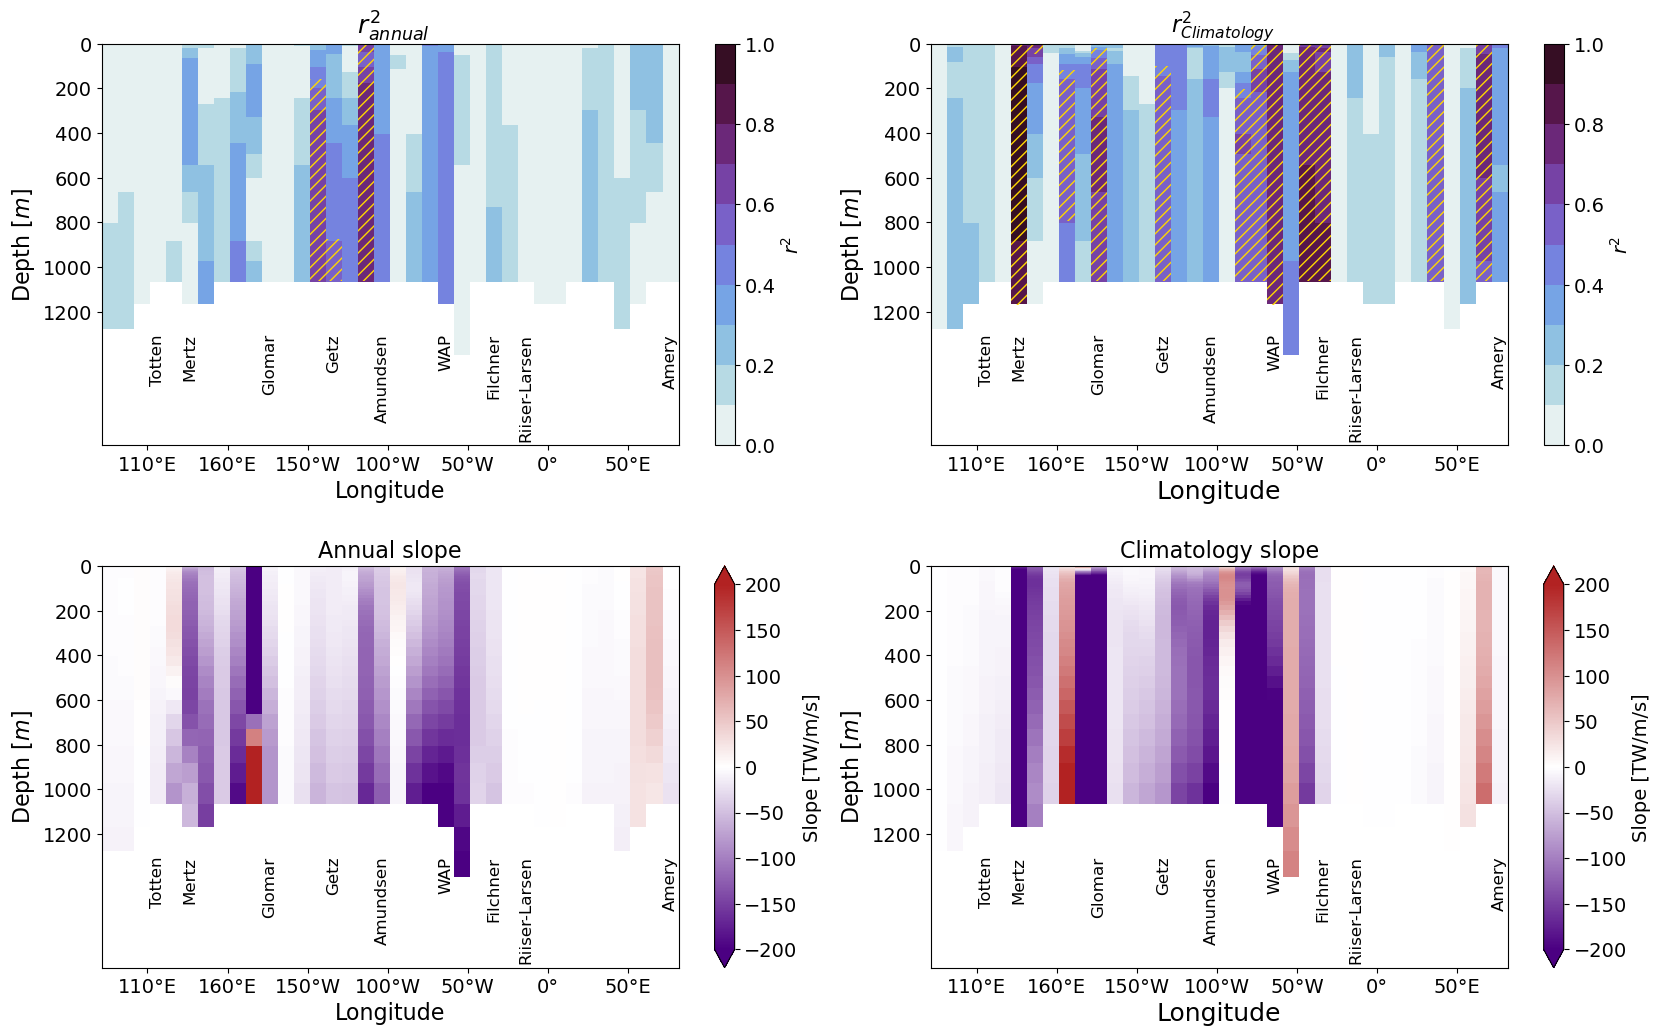

In [30]:
fig = plt.figure(figsize=(20,12))
plt.rcParams['hatch.color'] = 'gold'
plt.rcParams['font.size'] = 14
hatching_style='****'

plt.subplots_adjust( wspace=0.15, hspace=0.3)

ax0 = fig.add_subplot(2,2,1)
r2_annual.plot(y='st_ocean',cmap = discrete_cmap(10, cmocean.dense),vmin=0,vmax=1)
# plt.contourf(r2_annual.lon_bins,r2_annual.st_ocean,r2_annual,\
#              levels=[0.50001,0.6,0.7,0.8,0.9,1], hatches=hatching_style, colors='none',add_colorbar=False)
add_hatch_mask(ax0, r2_annual.lon_bins.values-5, r2_annual.st_ocean.values-50, r2_annual.values > 0.5)
plt.ylim(1800,0); plt.title(r' $r^2_{annual}$',fontsize = 18)
plt.ylabel(r'Depth [$m$]',fontsize = 16)
for i in range(9):
    plt.text(r2_annual.lon_bins[longitude_inds[i]], 1300, regions_abridged[i], rotation=90,fontsize=12, va='top', ha='center',color='black')
ax0.xaxis.set_major_formatter(LongitudeFormatter())
plt.xlabel('Longitude',fontsize = 16)
plt.yticks([0,200,400,600,800,1000,1200],fontsize=14)


ax01 = fig.add_subplot(2,2,3) # experimental_cmap
slope_annual.plot(y='st_ocean',cmap = experimental_cmap,vmin=-200,vmax=200)
plt.ylim(1800,0); plt.title(r'Annual slope',fontsize = 16)
plt.ylabel(r'Depth [$m$]',fontsize = 16)
for i in range(9):
    plt.text(r2_annual.lon_bins[longitude_inds[i]], 1300, regions_abridged[i], rotation=90,fontsize=12, va='top', ha='center',color='black')
ax01.xaxis.set_major_formatter(LongitudeFormatter())
plt.xlabel('Longitude',fontsize = 16)
plt.yticks([0,200,400,600,800,1000,1200],fontsize=14)



ax1 = fig.add_subplot(2,2,2)
r2_dailyclim .plot(y='st_ocean', cmap = discrete_cmap(10, cmocean.dense),vmin=0,vmax=1)
# plt.contourf(r2_dailyclim.lon_bins,r2_dailyclim.st_ocean,r2_dailyclim ,\
#              levels=np.arange(0.500001,1,0.01), hatches=hatching_style, colors='none',add_colorbar=False)
add_hatch_mask(ax1, r2_dailyclim.lon_bins.values-5, r2_dailyclim.st_ocean.values-50, r2_dailyclim.values > 0.5)

plt.ylim(1800,0); plt.title(r' $r^2_{Climatology}$',fontsize = 16)
plt.ylabel(r'Depth [$m$]',fontsize = 16)
for i in range(9):
    plt.text(r2_dailyclim .lon_bins[longitude_inds[i]], 1300, regions_abridged[i], rotation=90,fontsize=12, va='top', ha='center',color='black')
ax1.xaxis.set_major_formatter(LongitudeFormatter())
plt.yticks([0,200,400,600,800,1000,1200],fontsize=14)
plt.xlabel('Longitude',fontsize = 18)



ax11 = fig.add_subplot(2,2,4)
slope_dailyclim .plot(y='st_ocean', cmap = experimental_cmap,vmin=-200,vmax=200)
plt.ylim(1800,0); plt.title(r'Climatology slope',fontsize = 16)
plt.ylabel(r'Depth [$m$]',fontsize = 16)
for i in range(9):
    plt.text(slope_dailyclim .lon_bins[longitude_inds[i]], 1300, regions_abridged[i], rotation=90,fontsize=12, va='top', ha='center',color='black')
ax11.xaxis.set_major_formatter(LongitudeFormatter())
plt.yticks([0,200,400,600,800,1000,1200],fontsize=14)
plt.xlabel('Longitude',fontsize = 18)

Adding comparisson with previous $r^2$

In [31]:
#importing previous correlations
files_path = '/g/data/ik11/users/wf4500/ASC_project_files/' # 10deg
file_extension = 'agemaskCDW_volav'
file_extension_daily_clima = 'agemaskCDW_daily'

ds = xr.open_dataset(files_path + 'r_sq_annual_10degBins_' + file_extension + '_corr.nc')
r_sq_annual_10deg = ds.r_sq_annual
ds.close()
ds = xr.open_dataset(files_path + 'slope_annual_10degBins_' + file_extension + '_corr.nc')
slope_sq_annual_10deg = ds.slope_annual
ds.close()


ds = xr.open_dataset(files_path + 'r_sq_clima_10degBins_' + file_extension_daily_clima + '_APR10.nc')
r_sq_daily_10deg = ds.r_sq_clim
ds.close()
ds = xr.open_dataset(files_path + 'slope_clima_10degBins_' + file_extension_daily_clima + '_APR10.nc')
slope_sq_daily_10deg = ds.slope_clima
ds.close()



In [32]:
import matplotlib.gridspec as gridspec

In [36]:
r_sq_daily_10deg.mean()

<xarray.DataArray 'r_sq_clim' ()> Size: 8B
array(0.32182962)

In [37]:
r_sq_annual_10deg.mean()

<xarray.DataArray 'r_sq_annual' ()> Size: 8B
array(0.27140228)

In [38]:
(r_sq_daily_10deg.mean()+r_sq_annual_10deg.mean())/2

<xarray.DataArray ()> Size: 8B
array(0.29661595)

/jobfs/154931058.gadi-pbs/ipykernel_2253783/3548735741.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = plt.cm.get_cmap(base_cmap)
/jobfs/154931058.gadi-pbs/ipykernel_2253783/3548735741.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = plt.cm.get_cmap(base_cmap)
/jobfs/154931058.gadi-pbs/ipykernel_2253783/3548735741.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = plt.cm.get_cmap(base_cmap)
/jobfs/154931058.gadi-pbs/ipykernel_2253783

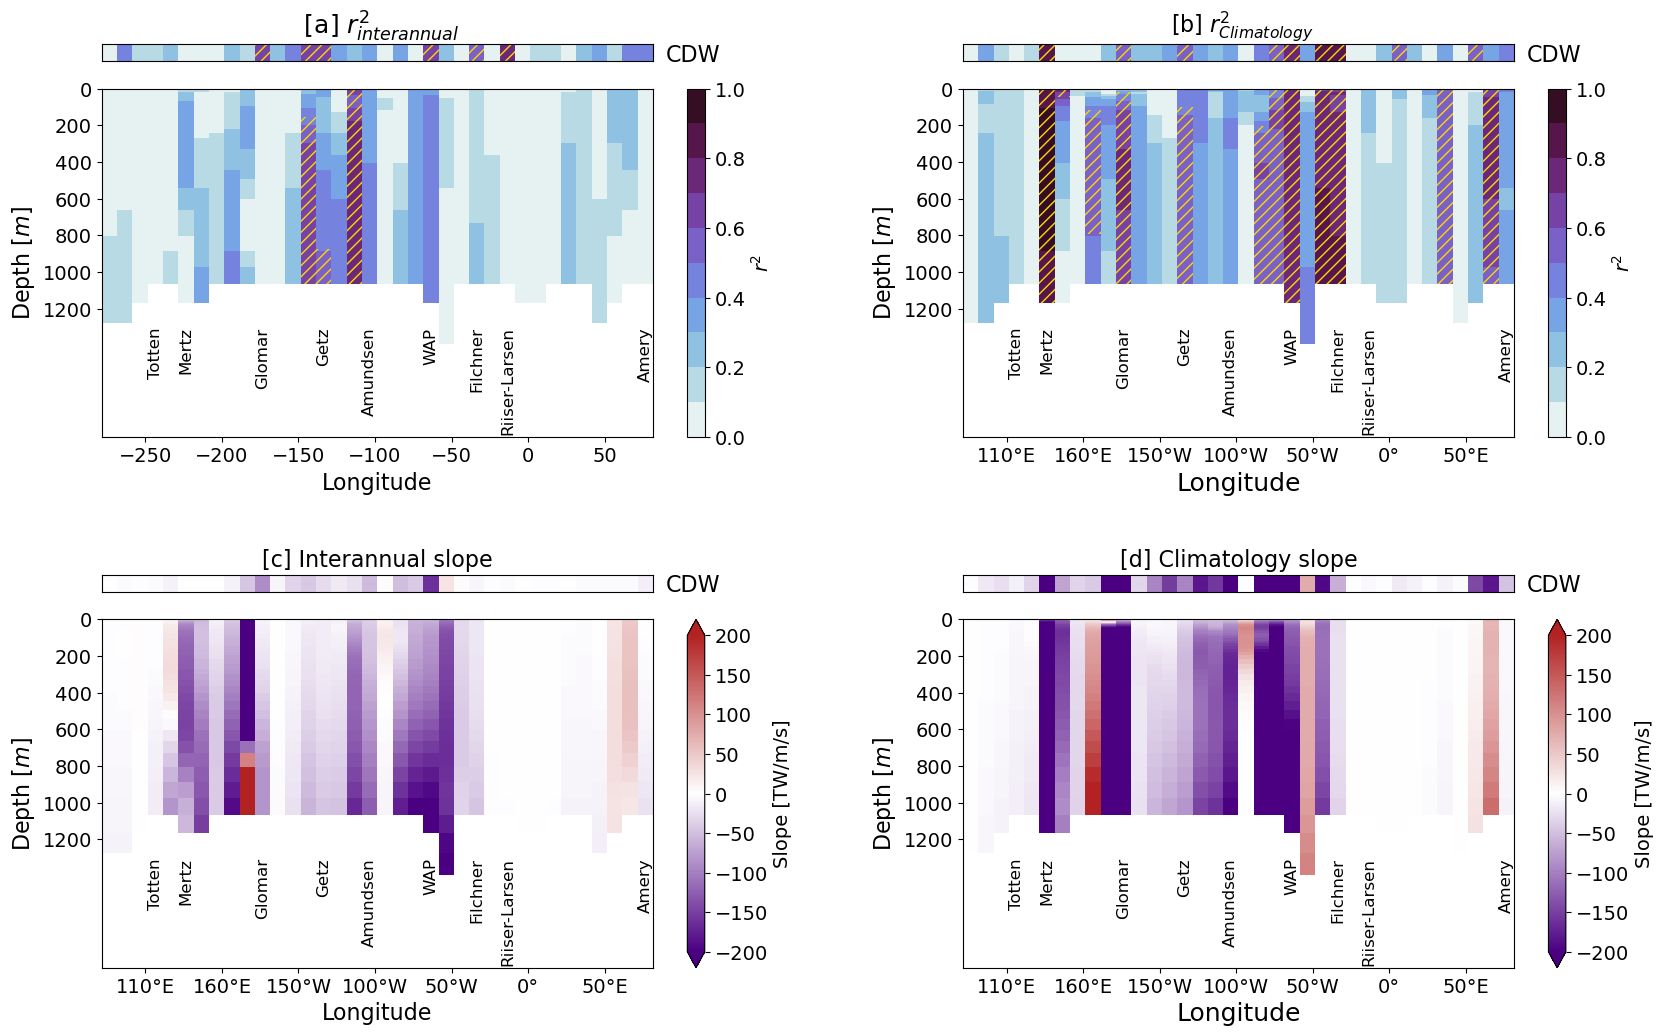

In [34]:
fig = plt.figure(figsize=(20, 12))

# Outer grid: 2 rows × 2 columns
outer = gridspec.GridSpec(2, 2, figure=fig, wspace=0.25, hspace=0.35)

# Top-left
gs11 = gridspec.GridSpecFromSubplotSpec(2, 5, subplot_spec=outer[0, 0],
                                        height_ratios=[1, 20], hspace=0.15)
ax_small1 = fig.add_subplot(gs11[0, :])
pos = ax_small1.get_position()
ax_small1.set_position([pos.x0, pos.y0, pos.width * 0.8, pos.height])
plt.title(r' [a] $r^2_{interannual}$',fontsize = 18)
ax_small1.pcolormesh([r_sq_annual_10deg.lon_bins,r_sq_annual_10deg.lon_bins],[-1 +r2_annual.lon_bins*0,1 + r2_annual.lon_bins*0],[r_sq_annual_10deg,r_sq_annual_10deg],cmap = discrete_cmap(10, cmocean.dense),vmin=0,vmax=1)
ax_small1.set_xticks(ticks=[]); ax_small1.set_yticks(ticks=[])
ax_small1.text(90,-2,'CDW',fontsize = 16)
r_sq_annual_10deg_stacked = np.stack((r_sq_annual_10deg,r_sq_annual_10deg))
add_hatch_mask(ax_small1, r_sq_annual_10deg.lon_bins-5,\
               [-2,2],r_sq_annual_10deg_stacked > 0.5)


ax_main1  = fig.add_subplot(gs11[1, :])  
r2_annual.plot(y='st_ocean',cmap = discrete_cmap(10, cmocean.dense),vmin=0,vmax=1)
add_hatch_mask(ax_main1, r2_annual.lon_bins.values-5, r2_annual.st_ocean.values-50, r2_annual.values > 0.5)
plt.ylim(1900,0); plt.title(r' ',fontsize = 18)
plt.ylabel(r'Depth [$m$]',fontsize = 16)
for i in range(9):
    plt.text(r2_annual.lon_bins[longitude_inds[i]], 1300, regions_abridged[i], rotation=90,fontsize=12, va='top', ha='center',color='black')
ax0.xaxis.set_major_formatter(LongitudeFormatter())
plt.xlabel('Longitude',fontsize = 16)
plt.yticks([0,200,400,600,800,1000,1200],fontsize=14)






# === Top-right cell ===
gs12 = gridspec.GridSpecFromSubplotSpec(2, 5, subplot_spec=outer[0, 1],
                                        height_ratios=[1, 20], hspace=0.15)
ax_small2 = fig.add_subplot(gs12[0, :])
pos = ax_small2.get_position()
ax_small2.set_position([pos.x0, pos.y0, pos.width * 0.8, pos.height])
plt.title(r' [b] $r^2_{Climatology}$',fontsize = 16)
ax_small2.pcolormesh([r_sq_daily_10deg.lon_bins,r_sq_daily_10deg.lon_bins],[-1 +r_sq_daily_10deg.lon_bins*0,1 + r_sq_daily_10deg.lon_bins*0],[r_sq_daily_10deg,r_sq_daily_10deg],cmap = discrete_cmap(10, cmocean.dense),vmin=0,vmax=1)
ax_small2.set_xticks(ticks=[]); ax_small2.set_yticks(ticks=[])
ax_small2.text(90,-2,'CDW',fontsize = 16)
r_sq_daily_10deg_stacked = np.stack((r_sq_daily_10deg,r_sq_daily_10deg))
add_hatch_mask(ax_small2, r_sq_daily_10deg.lon_bins-5,\
               [-2,2],r_sq_daily_10deg_stacked > 0.5)



ax_main2  = fig.add_subplot(gs12[1, :])
r2_dailyclim .plot(y='st_ocean', cmap = discrete_cmap(10, cmocean.dense),vmin=0,vmax=1)
add_hatch_mask(ax_main2, r2_dailyclim.lon_bins.values-5, r2_dailyclim.st_ocean.values-50, r2_dailyclim.values > 0.5)

plt.ylim(1900,0); plt.title(r'',fontsize = 16)
plt.ylabel(r'Depth [$m$]',fontsize = 16)
for i in range(9):
    plt.text(r2_dailyclim .lon_bins[longitude_inds[i]], 1300, regions_abridged[i], rotation=90,fontsize=12, va='top', ha='center',color='black')
ax_main2.xaxis.set_major_formatter(LongitudeFormatter())
plt.yticks([0,200,400,600,800,1000,1200],fontsize=14)
plt.xlabel('Longitude',fontsize = 18)

# === Bottom-left cell ===
gs21 = gridspec.GridSpecFromSubplotSpec(2, 5, subplot_spec=outer[1, 0],
                                        height_ratios=[1, 20], hspace=0.15)
ax_small3 = fig.add_subplot(gs21[0, :])
pos = ax_small3.get_position()
ax_small3.set_position([pos.x0, pos.y0, pos.width * 0.8, pos.height])
plt.title(r'[c] Interannual slope',fontsize = 16)
ax_small3.pcolormesh([r_sq_daily_10deg.lon_bins,r_sq_daily_10deg.lon_bins],[-1 +r_sq_daily_10deg.lon_bins*0,1 + r_sq_daily_10deg.lon_bins*0],[slope_sq_annual_10deg,slope_sq_annual_10deg],cmap = experimental_cmap,vmin=-200,vmax=200)
ax_small3.set_xticks(ticks=[]); ax_small3.set_yticks(ticks=[])
ax_small3.text(90,-2,'CDW',fontsize = 16)



ax_main3  = fig.add_subplot(gs21[1, :])
slope_annual.plot(y='st_ocean',cmap = experimental_cmap,vmin=-200,vmax=200)
plt.ylim(1900,0); plt.title(r'',fontsize = 16)
plt.ylabel(r'Depth [$m$]',fontsize = 16)
for i in range(9):
    plt.text(r2_annual.lon_bins[longitude_inds[i]], 1300, regions_abridged[i], rotation=90,fontsize=12, va='top', ha='center',color='black')
ax_main3.xaxis.set_major_formatter(LongitudeFormatter())
plt.xlabel('Longitude',fontsize = 16)
plt.yticks([0,200,400,600,800,1000,1200],fontsize=14)

# # === Bottom-right cell ===
gs22 = gridspec.GridSpecFromSubplotSpec(2, 5, subplot_spec=outer[1, 1],
                                        height_ratios=[1, 20], hspace=0.15)
ax_small4 = fig.add_subplot(gs22[0, :])
pos = ax_small4.get_position()
ax_small4.set_position([pos.x0, pos.y0, pos.width * 0.8, pos.height])
plt.title(r'[d] Climatology slope',fontsize = 16)
ax_small4.pcolormesh([r_sq_daily_10deg.lon_bins,r_sq_daily_10deg.lon_bins],[-1 +r_sq_daily_10deg.lon_bins*0,1 + r_sq_daily_10deg.lon_bins*0],[slope_sq_daily_10deg,slope_sq_daily_10deg],cmap = experimental_cmap,vmin=-200,vmax=200)
ax_small4.set_xticks(ticks=[]); ax_small4.set_yticks(ticks=[])
ax_small4.text(90,-2,'CDW',fontsize = 16)


ax_main4  = fig.add_subplot(gs22[1, :])
slope_dailyclim .plot(y='st_ocean', cmap = experimental_cmap,vmin=-200,vmax=200)
plt.ylim(1900,0); plt.title(r' ',fontsize = 16)
plt.ylabel(r'Depth [$m$]',fontsize = 16)
for i in range(9):
    plt.text(slope_dailyclim .lon_bins[longitude_inds[i]], 1300, regions_abridged[i], rotation=90,fontsize=12, va='top', ha='center',color='black')
ax_main4.xaxis.set_major_formatter(LongitudeFormatter())
plt.yticks([0,200,400,600,800,1000,1200],fontsize=14)
plt.xlabel('Longitude',fontsize = 18)

plt.tight_layout()

#plt.savefig('/g/data/x77/wf4500/ASC_project/analysis_figs/ASCcorrs_Zlevels.png',dpi=300,bbox_inches='tight')

In [163]:
# fig = plt.figure(figsize=(20,12))
# plt.rcParams['hatch.color'] = 'gold'
# plt.rcParams['font.size'] = 14
# hatching_style='****'

# plt.subplots_adjust( wspace=0.15, hspace=0.3)

# # Define the GridSpec with 2 rows and 2 columns
# gs = gridspec.GridSpec(2, 2, figure=fig)

# # Create subplots referencing the grid locations
# ax0 = fig.add_subplot(gs[0, 0])  # Row 0, Col 0
# ax1 = fig.add_subplot(gs[0, 1])  # Row 0, Col 1
# ax01 = fig.add_subplot(gs[1, 0])  # Row 1, Col 0
# ax11 = fig.add_subplot(gs[1, 1])  # Row 1, Col 1




# ax0 = fig.add_subplot(2,2,1)
# r2_annual.plot(y='st_ocean',cmap = discrete_cmap(10, cmocean.dense),vmin=0,vmax=1)
# add_hatch_mask(ax0, r2_annual.lon_bins.values-5, r2_annual.st_ocean.values-50, r2_annual.values > 0.5)
# plt.ylim(1800,0); plt.title(r' $r^2_{annual}$',fontsize = 18)
# plt.ylabel(r'Depth [$m$]',fontsize = 16)
# for i in range(9):
#     plt.text(r2_annual.lon_bins[longitude_inds[i]], 1300, regions_abridged[i], rotation=90,fontsize=12, va='top', ha='center',color='black')
# ax0.xaxis.set_major_formatter(LongitudeFormatter())
# plt.xlabel('Longitude',fontsize = 16)
# plt.yticks([0,200,400,600,800,1000,1200],fontsize=14)


# ax01 = fig.add_subplot(2,2,3) # experimental_cmap
# slope_annual.plot(y='st_ocean',cmap = experimental_cmap,vmin=-200,vmax=200)
# plt.ylim(1800,0); plt.title(r'Annual slope',fontsize = 16)
# plt.ylabel(r'Depth [$m$]',fontsize = 16)
# for i in range(9):
#     plt.text(r2_annual.lon_bins[longitude_inds[i]], 1300, regions_abridged[i], rotation=90,fontsize=12, va='top', ha='center',color='black')
# ax01.xaxis.set_major_formatter(LongitudeFormatter())
# plt.xlabel('Longitude',fontsize = 16)
# plt.yticks([0,200,400,600,800,1000,1200],fontsize=14)



# ax1 = fig.add_subplot(2,2,2)
# r2_dailyclim .plot(y='st_ocean', cmap = discrete_cmap(10, cmocean.dense),vmin=0,vmax=1)
# add_hatch_mask(ax1, r2_dailyclim.lon_bins.values-5, r2_dailyclim.st_ocean.values-50, r2_dailyclim.values > 0.5)

# plt.ylim(1800,0); plt.title(r' $r^2_{Climatology}$',fontsize = 16)
# plt.ylabel(r'Depth [$m$]',fontsize = 16)
# for i in range(9):
#     plt.text(r2_dailyclim .lon_bins[longitude_inds[i]], 1300, regions_abridged[i], rotation=90,fontsize=12, va='top', ha='center',color='black')
# ax1.xaxis.set_major_formatter(LongitudeFormatter())
# plt.yticks([0,200,400,600,800,1000,1200],fontsize=14)
# plt.xlabel('Longitude',fontsize = 18)



# ax11 = fig.add_subplot(2,2,4)
# slope_dailyclim .plot(y='st_ocean', cmap = experimental_cmap,vmin=-200,vmax=200)
# plt.ylim(1800,0); plt.title(r'Climatology slope',fontsize = 16)
# plt.ylabel(r'Depth [$m$]',fontsize = 16)
# for i in range(9):
#     plt.text(slope_dailyclim .lon_bins[longitude_inds[i]], 1300, regions_abridged[i], rotation=90,fontsize=12, va='top', ha='center',color='black')
# ax11.xaxis.set_major_formatter(LongitudeFormatter())
# plt.yticks([0,200,400,600,800,1000,1200],fontsize=14)
# plt.xlabel('Longitude',fontsize = 18)



## Estimating rate of heat transport explained by correlations circumpolarly

I want to extimate, based on the regression slopes, how much of the total variability rate in heat transport is explained by each regression. For that I can multiply the regression slopes by either the range in ASC speed or the its standard deviation, and sum that circumpolarly

In [32]:
#importing old slopes and regressions
files_path = '/g/data/ik11/users/wf4500/ASC_project_files/' # 10deg
file_extension = 'agemaskCDW_volav'
file_extension_daily_clima = 'agemaskCDW_daily'

ds = xr.open_dataset(files_path + 'r_sq_annual_10degBins_' + file_extension + '_corr.nc')
r_sq_annual_10deg = ds.r_sq_annual
ds.close()
ds = xr.open_dataset(files_path + 'r_sq_all_10degBins_' + file_extension + '_corr.nc')
r_sq_all_10deg = ds.r_sq_all
ds.close()

# ds = xr.open_dataset(files_path + 'r_sq_clima_10degBins_' + file_extension + '_APR10.nc')
# r_sq_clima_10deg = ds.r_sq_clim
# ds.close()

ds = xr.open_dataset(files_path + 'r_sq_clima_10degBins_' + file_extension_daily_clima + '_APR10.nc')
r_sq_daily_10deg = ds.r_sq_clim
ds.close()
ds = xr.open_dataset(files_path + 'r_sq_clima_10degBins_' + file_extension_daily_clima + '_APR10_noZC.nc')
r_sq_daily_10deg_noZC = ds.r_sq_clim
ds.close()


ds = xr.open_dataset(files_path + 'slope_annual_10degBins_' + file_extension + '_corr.nc')
slope_sq_annual_10deg = ds.slope_annual
ds.close()
ds = xr.open_dataset(files_path + 'slope_all_10degBins_' + file_extension + '_corr.nc')
slope_sq_all_10deg = ds.slope_all
ds.close()

# ds = xr.open_dataset(files_path + 'slope_clima_10degBins_' + file_extension + '_APR10.nc')
# slope_sq_clima_10deg = ds.slope_clima
# ds.close()

ds = xr.open_dataset(files_path + 'slope_clima_10degBins_' + file_extension_daily_clima + '_APR10.nc')
slope_sq_daily_10deg = ds.slope_clima
ds.close()
ds = xr.open_dataset(files_path + 'slope_clima_10degBins_' + file_extension_daily_clima + '_APR10_noZC.nc')
slope_sq_daily_10deg_noZC = ds.slope_clima
ds.close()

In [63]:
u_along_rho = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/ASC_sigma_daily_10deg/OM2_01_iaf_cycle3/*.nc').U
Vol_rho = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/volume_daily_10deg/OM2_01_iaf_cycle3/*.nc').Volume

In [100]:
Vol_rhomean=Vol_rho.sum('potrho0').mean('time').compute()

In [70]:
#aSC in CDW layers
ASC_CDW = (u_along_rho  * age_mask_daily.CDW_mask).weighted((Vol_rho * age_mask_daily.CDW_mask).fillna(0)).mean('potrho0').compute()
ASC_CDW_circumpolar = (u_along_rho  * age_mask_daily.CDW_mask).weighted((Vol_rho * age_mask_daily.CDW_mask).fillna(0)).mean(('potrho0','lon_bins')).compute()

In [113]:
ASC_CDW_circumpolar_annual = ASC_CDW_circumpolar.resample(time='1Y').mean()
ASC_CDW_circumpolar_clim = ASC_CDW_circumpolar.groupby('time.dayofyear').mean()

ASC_CDW_annual = ASC_CDW.resample(time='1Y').mean()
ASC_CDW_clim = ASC_CDW.groupby('time.dayofyear').mean()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/xarray/groupers.py:530: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/xarray/groupers.py:530: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


In [147]:
# slope_sq_annual_10deg#annuals
# slope_annual, stderr_annual, r2_annual = correlation_analysis(u_along_mean_annual_z_forcorr,\
#                                                               CSHT_CDW_annual)

# #daily_climatology
# slope_dailyclim, stderr_dailyclim, r2_dailyclim = correlation_analysis(u_along_mean_z_dayclim,\
#                                                                        CSHT_CDW_dayclim)



#first, calculating range in CSHT [in Watts]
CSHT_CDW_annual_range = CSHT_CDW_annual.sum('lon_bins').max() - CSHT_CDW_annual.sum('lon_bins').min() 
CSHT_CDW_dayclim_range = CSHT_CDW_dayclim.sum('lon_bins').max() - CSHT_CDW_dayclim.sum('lon_bins').min()
#first, calculating range in CSHT [in Watts]
CSHT_CDW_annual_sd = CSHT_CDW_annual.sum('lon_bins').std()
CSHT_CDW_dayclim_sd = CSHT_CDW_dayclim.sum('lon_bins').std()



#second calcualting the range of variability in the ASC [m/s]
ASC_CDW_annual_range = ASC_CDW_annual.max('time') -ASC_CDW_annual.min('time')
ASC_CDW_clim_range = ASC_CDW_clim.max('dayofyear') - ASC_CDW_clim.min('dayofyear')
ASC_CDW_annual_sd = ASC_CDW_annual.std('time')
ASC_CDW_clim_sd = ASC_CDW_clim.std('dayofyear')

# #CSHT range predicted by slope
CSHT_pred_annual_range = ( slope_sq_annual_10deg*ASC_CDW_annual_range).sum()
CSHT_pred_clim_range = ( slope_sq_daily_10deg*ASC_CDW_clim_range).sum()
CSHT_pred_annual_sd = ( slope_sq_annual_10deg*ASC_CDW_annual_sd).sum()

CSHT_pred_clim_std = ( slope_sq_daily_10deg*ASC_CDW_clim_sd).sum()


<xarray.DataArray ()> Size: 8B
array(-17.80791708)

In [145]:
CSHT_CDW_annual_sd*1e-12,CSHT_pred_annual_sd

(<xarray.DataArray ()> Size: 8B
 array(13.34111893),
 <xarray.DataArray ()> Size: 8B
 array(-1.93216995))

In [148]:
CSHT_CDW_dayclim_range*1e-12,CSHT_pred_clim_std

(<xarray.DataArray ()> Size: 8B
 array(41.501593),
 <xarray.DataArray ()> Size: 8B
 array(-17.80791708))